In [3]:
from os import getcwd
from os.path import join, basename
from sys import path 
import numpy as np
import matplotlib.pyplot as plt

libs_dir = join("/".join(getcwd().split("/")[:-2]))
path.append(libs_dir)

filename = basename(globals()['__vsc_ipynb_file__']).split(".")[0]

import numpy as np
from libs.qchannel_model import *
import matplotlib.pyplot as plt
from libs.figure_config import *
from libs.default_parameters import *
# from libs.simulation_tools import *
from libs.satellite import *

In [4]:
satellite_1293 = LEOsatellite(
    libs_dir + '/data/STARLINK_1293.txt')
location_aizu = np.loadtxt(
    libs_dir + '/data/ogs_loc.txt')
location_sendai = np.loadtxt(
    libs_dir + '/data/ogs_loc_sendai.txt')
year = 2021
day = 357
hour = 16
minute = 29

t = np.arange(0, 241, 10) 
second = 56 + t 
utc = 9

latitude_bob = location_aizu[:, 0]
longitude_bob = location_aizu[:, 1]
elevation_bob = location_aizu[:, 2]

latitude_alice = location_sendai[:, 0]
longitude_alice = location_sendai[:, 1]
elevation_alice = location_sendai[:, 2]

# bob用のリスト
slant_path_bob_lst = np.zeros(len(second))
zenith_angle_bob_lst = np.zeros(len(second))

# alice用のリスト
slant_path_alice_lst = np.zeros(len(second))
zenith_angle_alice_lst = np.zeros(len(second))

for idx in range(len(second)):
    # bobとの幾何学的関係を計算
    slant_path_bob_lst[idx], zenith_angle_bob_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_bob[0], latitude_bob[0], elevation_bob[0] # bobが単一の場合、[0]でアクセス
    )

    slant_path_alice_lst[idx], zenith_angle_alice_lst[idx] = satellite_1293.computeGeometricWithUser(
        year, day, hour, minute, second[idx], utc,
        longitude_alice[0], latitude_alice[0], elevation_alice[0]
    )

# zenith_angle_alice, zenith_angle_bobのリスト
zenith_angle_alice_deg = zenith_angle_alice_lst
zenith_angle_bob_deg = zenith_angle_bob_lst

slant_path_bob_lst = slant_path_bob_lst * 1000
slant_path_alice_lst = slant_path_alice_lst * 1000

In [5]:
tau_zen_lst = np.array([0.81])

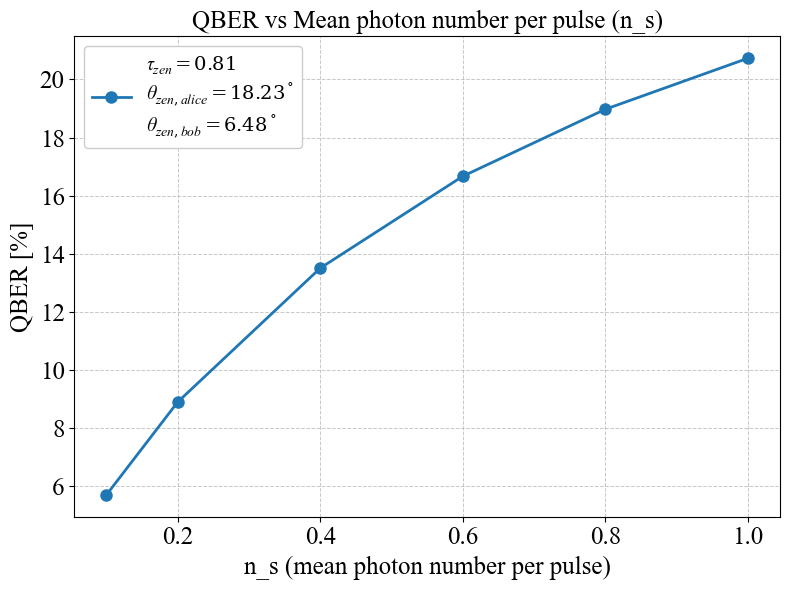

In [9]:

# n_sのリスト（ファイル名から推定）
n_s_list = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
file_list = [
    'qber_analysis_bbm92_test1_n_s01_new.npy',
    'qber_analysis_bbm92_test1_n_s02_new.npy',
    'qber_analysis_bbm92_test1_n_s04_new.npy',
    'qber_analysis_bbm92_test1_n_s06_new.npy',
    'qber_analysis_bbm92_test1_n_s08_new.npy',
    'qber_analysis_bbm92_test1_n_s1_new.npy'
]

# zenith_angle_alice, zenith_angle_bobのリスト
zenith_angle_alice_deg = np.array([59.82220731, 57.20571, ..., 18.22698245906105, ...])
zenith_angle_bob_deg = np.array([59.12231128, 56.36761957, ..., 6.481713279678587, ...])

# 対象のインデックスを取得
# Ellipsis (...) in the array causes TypeError. Remove Ellipsis before searching.
zenith_angle_alice_deg_clean = np.array([v for v in zenith_angle_alice_deg if not isinstance(v, type(Ellipsis))])
idx_alice = np.where(np.isclose(zenith_angle_alice_deg_clean, 18.22698245906105))[0][0]
# Remove Ellipsis from zenith_angle_bob_deg before searching
zenith_angle_bob_deg_clean = np.array([v for v in zenith_angle_bob_deg if not isinstance(v, type(Ellipsis))])
idx_bob = np.where(np.isclose(zenith_angle_bob_deg_clean, 6.481713279678587))[0][0]

qber_vs_ns = {tau: [] for tau in tau_zen_lst}

for file in file_list:
    qber_values = np.load(f'results/{file}')  # shape: (3, N)
    for i, tau in enumerate(tau_zen_lst):
        # tau_zenごとにQBERを抽出
        qber_vs_ns[tau].append(qber_values[i][idx_alice])

plt.figure(figsize=(8, 6))
for tau in tau_zen_lst:
    plt.plot(n_s_list, np.array(qber_vs_ns[tau])*100, marker='o', label=f'tau_zen={tau}', linewidth=2)
plt.xlabel('n_s (mean photon number per pulse)', fontsize=18)
plt.ylabel('QBER [%]', fontsize=18)
plt.title('QBER vs Mean photon number per pulse (n_s)', fontsize=18)
plt.xlabel('n_s (mean photon number per pulse)', fontsize=18)
plt.ylabel('QBER [%]', fontsize=18)
plt.title('QBER vs Mean photon number per pulse (n_s)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(
    [
        f"$\\tau_{{zen}}={tau}$\n$\\theta_{{zen,alice}}={zenith_angle_alice_deg_clean[idx_alice]:.2f}^\\circ$\n$\\theta_{{zen,bob}}={zenith_angle_bob_deg_clean[idx_bob]:.2f}^\\circ$"
        for tau in tau_zen_lst
    ],
    fontsize=14
)
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.savefig('figure_results/qber_vs_ns.pdf', bbox_inches='tight')
plt.tight_layout()
plt.show()